In [69]:
import collections
import statistics
from typing import Iterator

import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
from plotnine import *
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate

# Table of Contents

- [Step 1](#Step-1)
- [Step 2](#Step-2-+-Step-3)
- [Step 3](#Step-2-+-Step-3)
- [Step 4](#Step-4)
- [Step 5](#Step-5)
- [Step 6](#Step-6)
- [Step 7](#Step-4)
- [Step 8](#Step-5)
- [Step 9](#Step-6)
- [Step 10](#Step-10)

In [19]:
def inspect_df(df: pd.DataFrame, n: int = 5) -> pd.DataFrame:
    """Helper method to easily inspect DataFrames."""

    print(f"shape: {df.shape}")

    return df.head(n)

In [3]:
# dataset source: https://grouplens.org/datasets/movielens/
!wget --backups=1 https://files.grouplens.org/datasets/movielens/ml-latest-small.zip -P data/

--2022-03-18 15:31:01--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Failed to rename data/ml-latest-small.zip to data/ml-latest-small.zip.1: (2) No such file or directory
Saving to: ‘data/ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   297KB/s    in 3.2s    

2022-03-18 15:31:05 (297 KB/s) - ‘data/ml-latest-small.zip’ saved [978202/978202]



In [4]:
# if `unzip` does not exist in your system: apt-get install unzip
!unzip -o data/ml-latest-small.zip -d data/

Archive:  data/ml-latest-small.zip
   creating: data/ml-latest-small/
  inflating: data/ml-latest-small/links.csv  
  inflating: data/ml-latest-small/tags.csv  
  inflating: data/ml-latest-small/ratings.csv  
  inflating: data/ml-latest-small/README.txt  
  inflating: data/ml-latest-small/movies.csv  


## Step 1

In [4]:
# Formulate the optimization problem (similarly to the formulation in Unit 5). Your
# optimization problem will relate to the prediction error in the training dataset.
# Make sure you understand the unknowns of the problem, and what you are trying to optimize.

## Step 2 + Step 3

In [33]:
reader = Reader(
    line_format="user item rating timestamp", sep=",", skip_lines=1, rating_scale=(1, 5)
)

In [34]:
data = Dataset.load_from_file("data/ml-latest-small/ratings.csv", reader=reader)

## Step 4

In [54]:
recsys_small = SVD(
    n_factors=4,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [55]:
recsys_large = SVD(
    n_factors=20,
    n_epochs=50,
    biased=True,  # use baselines
    random_state=123456,
)

In [58]:
cv_results = {}

cv_results["SVD w/ 4 factors"] = cross_validate(
    recsys_small,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7573  0.7585  0.7633  0.7525  0.7631  0.7589  0.0040  
RMSE (testset)    0.8703  0.8709  0.8737  0.8675  0.8736  0.8712  0.0023  
MAE (testset)     0.6659  0.6674  0.6683  0.6631  0.6678  0.6665  0.0019  
MSE (trainset)    0.5110  0.5065  0.5063  0.5099  0.5052  0.5078  0.0023  
RMSE (trainset)   0.7149  0.7117  0.7116  0.7141  0.7108  0.7126  0.0016  
MAE (trainset)    0.5504  0.5476  0.5478  0.5495  0.5469  0.5484  0.0013  
Fit time          1.81    1.77    1.88    1.95    1.86    1.85    0.06    
Test time         0.12    0.13    0.12    0.12    0.16    0.13    0.01    


In [59]:
cv_results["SVD w/ 20 factors"] = cross_validate(
    recsys_large,
    data=data,
    measures=["mse", "rmse", "mae"],
    return_train_measures=True,
    verbose=True,
    cv=5,
    n_jobs=-1,
)

Evaluating MSE, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MSE (testset)     0.7928  0.7890  0.7790  0.7706  0.7700  0.7803  0.0093  
RMSE (testset)    0.8904  0.8883  0.8826  0.8778  0.8775  0.8833  0.0053  
MAE (testset)     0.6802  0.6815  0.6765  0.6723  0.6699  0.6761  0.0044  
MSE (trainset)    0.3040  0.3026  0.3014  0.3028  0.3034  0.3028  0.0009  
RMSE (trainset)   0.5513  0.5501  0.5490  0.5503  0.5508  0.5503  0.0008  
MAE (trainset)    0.4255  0.4234  0.4229  0.4243  0.4248  0.4242  0.0009  
Fit time          3.28    3.30    3.26    3.26    3.27    3.27    0.02    
Test time         0.12    0.13    0.12    0.11    0.11    0.12    0.01    


In [64]:
df = pd.DataFrame(cv_results).T.reset_index()

df["mean RMSE (train)"] = df["train_rmse"].map(lambda x: statistics.mean(x))

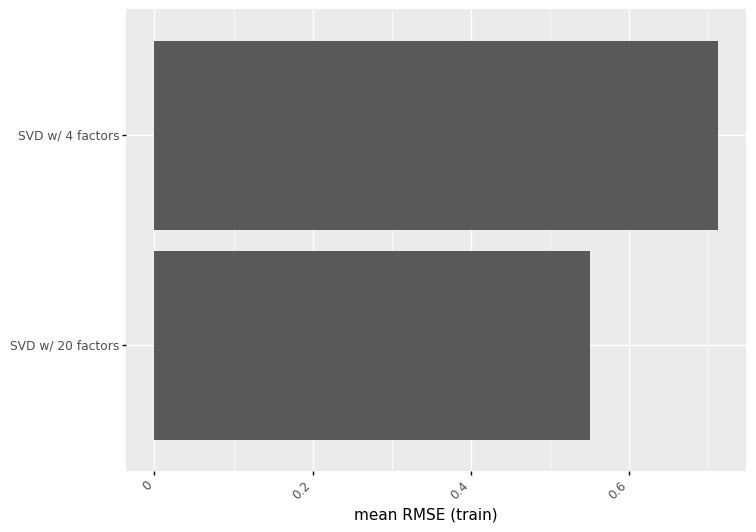

<ggplot: (8761071990260)>

In [65]:
(
    ggplot(df)
    + geom_col(aes(x="index", y="mean RMSE (train)"), stat="identity")
    + theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(8, 6))
    + labs(x="", y="mean RMSE (train)")
    + coord_flip()
)

## Step 5

In [83]:
ratings = pd.read_csv(
    "data/ml-latest-small/ratings.csv",
    usecols=["user", "item", "rating"],
    names=["user", "item", "rating"],
    skiprows=1,
)

inspect_df(ratings)

shape: (100836, 3)


,user,item,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [84]:
ratings["user"] = ratings.groupby("user").ngroup()

In [86]:
ratings["item"] = ratings.groupby("item").ngroup()

In [70]:
def create_tf_datasets(
    data: pd.DataFrame,
    batch_size: int = 1,
    max_clients: int = None,
    max_items_per_user: int = None,
) -> Iterator[tf.data.Dataset]:

    n_users = len(data["userId"].unique())

    if max_clients is not None:
        n_users = min(n_users, max_clients)

    def transform_batch(batch: tf.Tensor) -> collections.OrderedDict:

        return collections.OrderedDict(
            x=tf.cast(batch[:, 0:2], tf.int64), y=tf.cast(batch[:, 2:3], tf.float32)
        )

    for _, user_ratings in data.groupby("userId"):

        if n_users < 0:
            break

        tf_dataset = tf.data.Dataset.from_tensor_slices(user_ratings)

        yield (
            tf_dataset.take(max_items_per_user)
            .shuffle(buffer_size=max_items_per_user, seed=42)
            .batch(batch_size)
            .map(transform_batch, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        )

        n_users -= 1

## Step 6

## Step 7

## Step 8

## Step 9

## Step 10